# Crater DEMs and Hillshades

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
import rasterio
from rasterio.plot import show
import tempfile
from osgeo import gdal  # If this line causes trouble, try `import gdal`
import os
from affine import Affine
from scipy.optimize import curve_fit
from scipy.ndimage import interpolation as intp
from pathlib import Path

plt.rc('figure', **{'figsize': (10, 8)})

In [2]:
dataloc = Path('../data/UMKC')

## Helpers

### Adjustment Functions for Transforms/Coordinate Systems

#### `centroid()`

In [3]:
def centroid(x, y):
    return x.sum(axis=0) / len(x), y.sum(axis=0) / len(y)

#### `adjust()`

Adjusts selected coordinates by offset and rotation around z-axis. Meant to be called by a fit function.
1. Shift (x, y)-coordinates by `xoff`, `yoff`
2. Rotate (x, y)-coordinates by `angle` around the centroid of (x + xoff, y + yoff)
3. Shift z-coordinates by `zoff`

In [4]:
def adjust(bpos, xoff, yoff, zoff, angle, scale) -> ndarray:
    """Adjusts selected coordinates by offset and rotation around z-axis. Meant
    to be called by a fit function.
    
    Returns
    -------
    Returns the adjusted block locations.
    """
    i = len(bpos) // 3
    bx, by, bz = bpos[:i], bpos[i:2 * i], bpos[2 * i:]
    cx, cy = centroid(bx + xoff, by + yoff)
    rot = Affine.rotation(angle, pivot=(cx, cy))
    trans = Affine.translation(xoff, yoff)
    sct = Affine.scale(scale)
    ret = [rot * (sct * (trans * coords[:2])) + (coords[2] + zoff,)
           for coords in zip(bx, by, bz)]
    return np.array(
        [r[0] for r in ret] + [r[1] for r in ret] + [r[2] for r in ret]
    )

#### `adjust_transform()`

Calculate a transform that fits raw block locations (as they show up in not adjusted
raster DEMs) to reference locations as measured by the total station at smallest
possible deviation without changing their relative positions.

In [5]:
def adjust_transform(raw, ref, pivot, scale: bool = False) -> tuple:
    """Transform raw block coordinates to reference values.
    
    Parameters
    ----------
    raw : ndarray
        Raw block coordinates.
    ref : ndarray
        Reference block locations.
    pivot : iterable
        Pivot location for rotation. E.g. the centroid of the raw locations.
    scale : bool
        Whether to adjust the scale of the transform.
    
    Returns
    -------
    Returns the tuple (`pars`, `transform`) containing (a) the transform
    parameters `pars` = [xoff, yoff, angle, scale] and (b) the
    corresponding affine `transform` object. If the scale parameter is false a
    scale parameter will be 1 in the return value.
    """
    p0 = [0., 0., 0., 0.]  # Initial guess [xoff, yoff, scale, angle]
    bounds = (
        [-1., -1., -1., -10.],
        [+1., +1., +1., +10.],
    )
    if scale:
        func = adjust
        p0 += [1.]
        bmn, bmx = bounds
        bounds = (bmn + [0.8], bmx + [1.2])
    else:
        def aadjust(bpos, xoff, yoff, zoff, angle):
            return adjust(bpos, xoff, yoff, zoff, angle, 1)
        func = aadjust
    res = curve_fit(
        func,
        np.concatenate((raw[:, 0], raw[:, 1], raw[:, 2])),
        np.concatenate((ref[:, 0], ref[:, 1], ref[:, 2])),
        p0=p0, bounds=bounds, method='dogbox',
        maxfev=1000000
    )
#     print(res)
    pars = res[0]
    l = Affine.translation(pars[0], pars[1])
    r = Affine.rotation(pars[3], pivot=pivot)
    rett = r * l
    if scale:
        rett = Affine.scale(pars[4]) * rett
    return pars, rett

#### `rotate_raster()`

Rotate raster data without changing the reference coordinate system.

In [6]:
def rotate_raster(rdata, angle, pivot) -> np.ma.MaskedArray:
    """Rotate raster data without changing the reference coordinate system.
    
    Parameters
    ----------
    rdata : masked ndarray
        The raster data.
    angle : float
        Rotation angle (degrees).
    pivot : iterable
        Pivot location
    
    Returns
    -------
    The rotated raster data
    """
    ly, lx = rdata.shape
    py, px = pivot
    pady = [0, 2 * py - ly] if 2 * py >= ly else [ly - 2 * py]
    padx = [0, 2 * px - lx] if 2 * px >= lx else [lx - 2 * px]
    fill_val = rdata.data.min()
    ret = np.pad(rdata, [pady, padx], mode='constant',
                 constant_values=fill_val)
    ret = intp.rotate(ret, angle=angle, reshape=False,
                      mode='constant', cval=fill_val)
    ret = np.ma.MaskedArray(
        data=ret,
        mask=np.logical_or(ret < rdata.min(), ret > rdata.max()),
        fill_value=np.nan
    )
    ret[ret.mask] = np.nan
    cpy, cpx = ret.shape
    cpy //= 2
    cpx //= 2
    starty = cpy - py
    endy = starty + ly
    startx = cpx - px
    endx = startx + lx
    ret = ret[starty:endy, startx:endx]
    return ret

#### `show_adjust()`

Show adjustments made to a dataset.

In [7]:
def show_adjust(ax, ds, raw, ref, pivot, trnf):
    """Show adjustments made to a coordinate system.
    
    Parameters
    ----------
    ax : matplotlib axes subplot
        Target to plot into.
    ds : rasterio.DatasetReader
        The raster data.
    raw : ndarray
        Unmodified coordinates.
    ref : ndarray
        Some reference
    pivot : array
        Center of rotation
    trnf : Affine
        Affine transform making adjustments.
    """
    show(ds, ax=ax, cmap=plt.cm.gray)
    ax.scatter(raw[:, 0], raw[:, 1], marker='x', color='white', label='raw')
    ax.scatter(ref[:, 0], ref[:, 1], marker='x', color='red', label='ref')
    
    xcorr, ycorr = [], []
    for xr, yr in zip(raw[:, 0], raw[:, 1]):
        x, y = trnf * (xr, yr)
        xcorr.append(x)
        ycorr.append(y)
    ax.scatter(xcorr, ycorr, marker='o', c='b', label='adjusted raw')
#     ax.scatter(*trnf * pivot, marker='o', c='g', label='adjusted centroid')
    ax.scatter(*trnf * centroid(np.array(xcorr), np.array(ycorr)),
               marker='o', c='g', label='adjusted centroid')
    ax.set_xlabel(r'$x\ / \mathrm{m}$')
    ax.set_ylabel(r'$y\ / \mathrm{m}$')
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))

### Hillshade Model Functions

#### `make_raw_hillshade()`

Make a raw model using `gdal`. Get raw data, and set mask as in the DEM.  
(I don't now how to give gdal the already opened `rasterio` dataset. It just likes to read from disk...)

In [8]:
def make_raw_hillshade(fname, mask) -> np.ma.MaskedArray:
    """Make a raw hillshade. Get raw data, and set mask as in the DEM.
    """
    opts = gdal.DEMProcessingOptions(
        format='GTiff', azimuth=305, altitude=55, band=1,
    )
    hsds = gdal.DEMProcessing(tempfile.NamedTemporaryFile(mode='w').name,
                              fname, 'hillshade', options=opts)
    return np.ma.array(hsds.GetRasterBand(1).ReadAsArray(), mask=mask)

#### `norm_hillshade()`

Normalize the hillshade to a range [-0.5, 0,5].

In [9]:
def norm_hillshade(hs):
    """Normalize the hillshade to a range [-0.5, 0,5]."""
    mn = hs.min()
    span = hs.max() - mn
    return (hs - mn) / span - 0.5

#### `norm_dem()`

Norms an array to values in [0, 1]

In [10]:
def norm_dem(dem):
    """Norms an array to values in [0, 1]."""
    mn = dem.min()
    span = dem.max() - mn
    return (dem - mn) / span

#### `fancy_hillshade()`
Make an improved hillshade model by adding up the [0, 1] normalized DEM, and the above hillshade multiplied by an amplitude < 1

In [11]:
def fancy_hillshade(dem: np.ndarray, fname: str, amp: float = 0.25):
    """Make an improved hillshade model by adding up the [0, 1] normalized
     DEM, and the above hillshade multiplied by an amplitude < 1
    """
    return norm_dem(dem) \
        + amp * norm_hillshade(make_raw_hillshade(fname, dem.mask))

### GeoTiff Functions

#### `make_geotiff()`

Saves raster data as a geotiff file to disk.

In [12]:
def make_geotiff(target, data, pds, alt_transform = None,
                 add_mask: ndarray = None):
    """Saves raster data as a geotiff file to disk."""
    if add_mask is not None:
        data.mask = np.logical_or(data.mask, add_mask)
    data.data[data.mask] = pds.nodata
    data.set_fill_value(pds.nodata)
    trnf = pds.transform if alt_transform is None else alt_transform
    # Necessary, to store the mask within the tiff
    with rasterio.Env(GDAL_TIFF_INTERNAL_MASK=True):
        with rasterio.open(
            target, mode='w', driver='GTiff', width=pds.width,
            height=pds.height, count=1, dtype=pds.dtypes[0], crs=pds.crs,
            transform=trnf, nodata=pds.nodata, sharing=True
        ) as nds:
#             nds.write_mask(data.mask)
            nds.write(data, 1)

#### `make_viewable_geotiff()`

New dataset with an 8-bit datatype, and otherwise same shape, extent, etc. as the DEM.

In [13]:
def make_viewable_geotiff(target, data, pds,
                          alt_transform: Affine = None,
                          add_mask: np.ndarray = None, add_jpeg: bool = False):
    if add_mask is not None:
        data.mask = np.logical_or(data.mask, add_mask)
    # re-normalize factors (after masking)
    mn = data.min()
    span = data.max() - mn
    trnf = pds.transform if alt_transform is None else alt_transform
    with rasterio.open(target, 'w', 'GTiff', pds.width, pds.height, 1, pds.crs,
                       trnf, 'uint8', 255, True) as nds:
        nds.write(np.asarray(255 * ((data - mn) / span), dtype=np.uint8), 1)
    if add_jpeg:
        with rasterio.Env(INTERNAL_MASK=True, QUALITY=100, EXIF_THUMBNAIL=True):
            with rasterio.open(
                target.parent / f"{target.stem}.jpg", 'w', 'JPEG',
                pds.width, pds.height, 1, pds.crs, trnf, 'uint8',
                255, True) as nds:
                nds.write(
                    np.asarray(255 * ((data - mn) / span), dtype=np.uint8), 1)

In [14]:
def convert_to_jpeg(fname):
    estr = 'convert "%s" -quality 100 "%s"' % (fname, fname[:-4] + '.jpg')
    os.system(estr)

## Pad 1

original location of dataset: `../data/GraettingerDEMs/elevation.3/raster.tif`

In [15]:
ds = rasterio.open(dataloc / 'Pad1/raster.tif')
ds.res

(0.00127582096821174, 0.0012758209682117404)

In [16]:
b1 = ds.read(1, masked=True)

### Corner blocks

- `raw`: Where the blocks show up in the raster.
- `ref`: Where the blocks should be, according to total station measurements.

In [17]:
raw = np.array([
    [15.06, 52.17, -1.36], [18.11, 51.98, -1.33],
    [14.86, 50.75, -1.32], [17.93, 50.09, -1.32]
])
ref = np.array([
    [14.975, 52.357, -1.368], [18.159, 52.183, -1.337],
    [14.714, 50.882, -1.341], [17.868, 50.276, -1.319]
])

Centroid location of raw data

In [18]:
cx, cy = centroid(raw[:, 0], raw[:, 1])
cx, cy

(16.490000000000002, 51.2475)

Raster index of centroid

In [19]:
ciy, cix = ds.index(cx, cy)
ciy, cix

(2449, 4295)

Fit of raw block locations to measured reference locations.

Parameters are:
`xoff, yoff, scale, angle`

In [20]:
pars, atr = adjust_transform(raw, ref, pivot=(cx, cy))
pars

array([-0.061     ,  0.177     , -0.00875   ,  0.05499293])

In [21]:
atr = Affine.translation(cx + pars[0], cy + pars[1]) \
    * Affine.translation(-cx, -cy)
tr2 = Affine.translation(cx + pars[0], cy + pars[1]) \
    * Affine.rotation(pars[3]) \
    * Affine.translation(-cx, -cy)
tr2

Affine(0.9999995393847052, -0.0009598074688806337, -0.01180467256237705,
       0.0009598074688806337, 0.9999995393847052, 0.16119637687263833)

#### Show adjusted locations 

(49.5, 53.0)

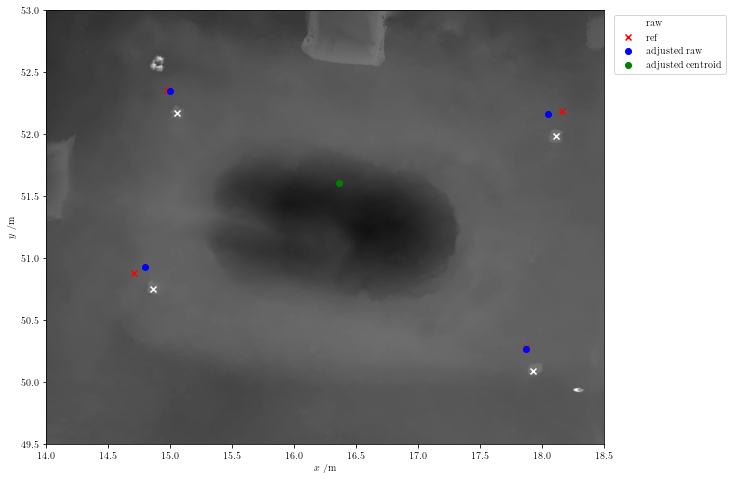

In [22]:
plt.close('all')
fig, ax = plt.subplots()

show_adjust(ax, ds, raw, ref, (cx, cy), tr2)
ax.set_xlim(14, 18.5); ax.set_ylim(49.5, 53)
# fig

### Rotate raster data to match reference transform

In [23]:
b2 = rotate_raster(b1, angle=pars[3], pivot=(ciy, cix))
b2 += pars[2]
b2.mask = np.isnan(b2.data)

In [24]:
rtrans = atr * ds.transform
fstub = f"pad1_{rtrans.a * 1e3:.3f}mm_"
fstub

'pad1_1.276mm_'

In [25]:
make_geotiff(dataloc / f"{fstub}dem.geo.tif",
             data=b1, pds=ds, alt_transform=rtrans, add_mask=b1.mask)

In [26]:
ds2 = rasterio.open(dataloc / f'{fstub}dem.geo.tif', mode='r')
b2 = ds2.read(1, masked=True)

In [27]:
plt.close('all')
fig, ax = plt.subplots()
show(ds2, ax=ax, cmap=plt.cm.gray)
ax.scatter(*ds2.transform * (cix, ciy), c='g')
ax.scatter(ref[:, 0], ref[:, 1])
ax.set_xlim(14, 18.5); ax.set_ylim(49.5, 53)
# fig

(49.5, 53.0)

#### Hillshade from DEM

In [28]:
make_viewable_geotiff(dataloc / f"{fstub}dem.tif", b2, ds2,
                      add_mask=np.logical_or(b2.mask, b2 > -1.2),add_jpeg=True)

In [29]:
h1 = fancy_hillshade(b2, ds2.files[0], amp=0.25)

(49.5, 53.0)

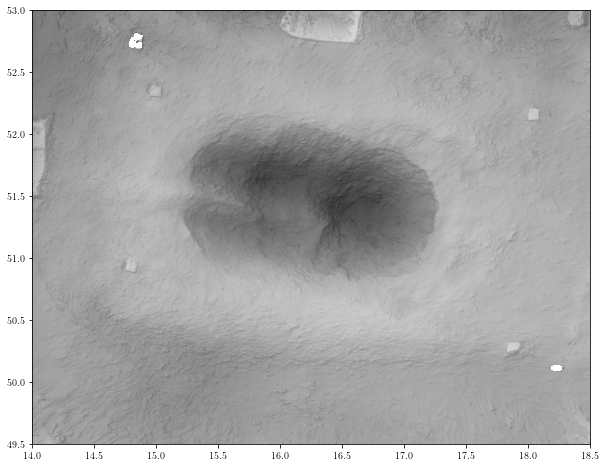

In [30]:
plt.close('all')
fig, ax = plt.subplots()
show(h1, ax=ax, transform=ds2.transform, cmap=plt.cm.gray)
ax.set_xlim(14, 18.5); ax.set_ylim(49.5, 53)
# fig

In [31]:
make_viewable_geotiff(
    dataloc / f"{fstub}hillshade.tif", h1, ds, alt_transform=rtrans,
    add_mask=b2 > -1.2, add_jpeg=True)

## Pad 2

original dataset location was at `../data/GraettingerDEMs/pad2high/w001001.adf`

In [32]:
ds = rasterio.open(dataloc / 'Pad2/elevation/w001001.adf')
ds.res

(0.001213758985, 0.001213758985)

In [33]:
b1 = ds.read(1, masked=True)

### Corner blocks

- `raw`: Where the blocks show up in the raster.
- `ref`: Where the blocks should be, according to total station measurements.

In [34]:
raw = np.array([
    [17.840, 52.040, -1.320], [21.749, 51.660, -1.320],
    [17.915, 50.113, -1.320], [21.490, 50.185, -1.290]
])
ref = np.array([
    [17.840, 52.305, -1.340], [21.702, 51.614, -1.332],
    [17.841, 50.291, -1.319], [21.435, 50.068, -1.303]
])

Centroid location of raw data

In [35]:
cx, cy = centroid(raw[:, 0], raw[:, 1])
cx, cy

(19.7485, 50.9995)

Raster index of centroid

In [36]:
ciy, cix = ds.index(cx, cy)
ciy, cix

(3988, 3529)

Fit raw block locations to reference values

`[xoff, yoff, scale, angle]`

In [37]:
pars, atr = adjust_transform(raw, ref, pivot=(cx, cy))
pars

array([-0.044     ,  0.07      , -0.011     , -4.02992801])

In [38]:
atr = Affine.translation(cx + pars[0], cy + pars[1]) \
    * Affine.translation(-cx, -cy)
tr2 = Affine.translation(cx + pars[0], cy + pars[1]) \
    * Affine.rotation(pars[3]) \
    * Affine.translation(-cx, -cy)

In [39]:
atr

Affine(1.0, 0.0, -0.04399999687699818,
       0.0, 1.0, 0.07000000201718137)

In [40]:
tr2

Affine(0.9975274774141777, 0.07027753413223357, -3.579290486567732,
       -0.07027753413223357, 0.9975274774141777, 1.5839733004432404)

#### Show adjustments

In [41]:
plt.close('all')
fig, ax = plt.subplots()
show_adjust(ax=ax, ds=ds, raw=raw, ref=ref, pivot=(cx, cy), trnf=tr2)
ax.set_xlim(17.5, 22.5); ax.set_ylim(49.5, 53)
# fig

(49.5, 53.0)

### Rotate raster data to match reference transform

In [42]:
b2 = rotate_raster(b1, pars[3], pivot=(ciy, cix))
b2 += pars[2]
b2.mask = np.isnan(b2.data)

In [43]:
dataloc

PosixPath('../data/UMKC')

In [44]:
rtrans = atr * ds.transform
fstub = f"pad2_{rtrans.a * 1e3:.3f}mm_"
fstub

'pad2_1.214mm_'

In [45]:
make_geotiff(dataloc / f"{fstub}dem.geo.tif", data=b2, pds=ds,
             alt_transform=rtrans, add_mask=b2.mask)

In [46]:
ds2 = rasterio.open(dataloc / f'{fstub}dem.geo.tif', mode='r')
b2 = ds2.read(1, masked=True)

(49.5, 53.0)

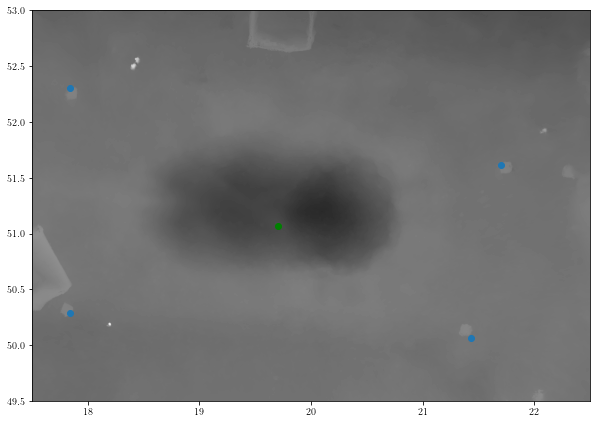

In [47]:
plt.close('all')
fig, ax = plt.subplots()
show(ds2, ax=ax, cmap=plt.cm.gray)
ax.scatter(*ds2.transform * (cix, ciy), c='g')
ax.scatter(ref[:, 0], ref[:, 1])
ax.set_xlim(17.5, 22.5); ax.set_ylim(49.5, 53)
# fig

#### Hillshade from DEM

In [48]:
make_viewable_geotiff(dataloc / f"{fstub}dem.tif", b2, ds2,
                      alt_transform=rtrans, add_mask=b2 > -1.2, add_jpeg=True)

/home/ingo/.local/opt/miniconda3/envs/chome/lib/python3.9/site-packages/numpy/ma/core.py:1158: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/home/ingo/.local/opt/miniconda3/envs/chome/lib/python3.9/site-packages/numpy/ma/core.py:1015: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [49]:
h1 = fancy_hillshade(b2, ds2.files[0], amp=0.25)

In [50]:
plt.close('all')
fig, ax = plt.subplots()
show(h1, ax=ax, transform=ds2.transform, cmap=plt.cm.gray)
ax.set_xlim(17.5, 22.5); ax.set_ylim(49.5, 53)
# fig

(49.5, 53.0)

In [51]:
make_viewable_geotiff(dataloc / f"{fstub}hillshade.tif", h1, ds2,
                      add_mask=b2 > -1.2, add_jpeg=True)

## Pad 3

In [52]:
ds = rasterio.open(dataloc / 'Pad3/Pad3high1.tif')
ds.res

(0.0014250000000000003, 0.0014250000000000003)

In [53]:
b1 = ds.read(1, masked=True)

### Corner blocks

- `raw`: Where the blocks show up in the raster.
- `ref`: Where the blocks should be, according to total station measurements.

In [54]:
raw = np.array([
    [22.185, 51.290, -1.320], [24.920, 51.340, -1.360],
    [21.900, 49.360, -1.290], [24.509, 48.467, -1.290]
])
ref = np.array([
    [22.221, 51.440, -1.331], [24.885, 51.581, -1.363],
    [21.978, 49.465, -1.295], [24.542, 48.569, -1.250]
])

Centroid of raw block locations

In [55]:
cx, cy = centroid(raw[:, 0], raw[:, 1])
cx, cy

(23.3785, 50.11425)

Raster index of centroid

In [56]:
ciy, cix = ds.index(cx, cy)
ciy, cix

(4289, 4719)

Fit of raw block locations to measured reference locations.

Returned parameters are:
`xoff, yoff, scale, angle`

In [57]:
pars, atr = adjust_transform(raw, ref, pivot=(cx, cy))
pars

array([0.028     , 0.1495    , 0.00525   , 1.13166286])

In [58]:
atr = Affine.translation(cx + pars[0], cy + pars[1]) \
    * Affine.translation(-cx, -cy)
tr2 = Affine.translation(cx + pars[0], cy + pars[1]) \
    * Affine.rotation(pars[3]) \
    * Affine.translation(-cx, -cy)
tr2

Affine(0.9998049505418518, -0.019749958784902093, 1.022314336047593,
       0.019749958784902093, 0.9998049505418518, -0.3024496534833787)

Show adjustments

(48.25, 52.0)

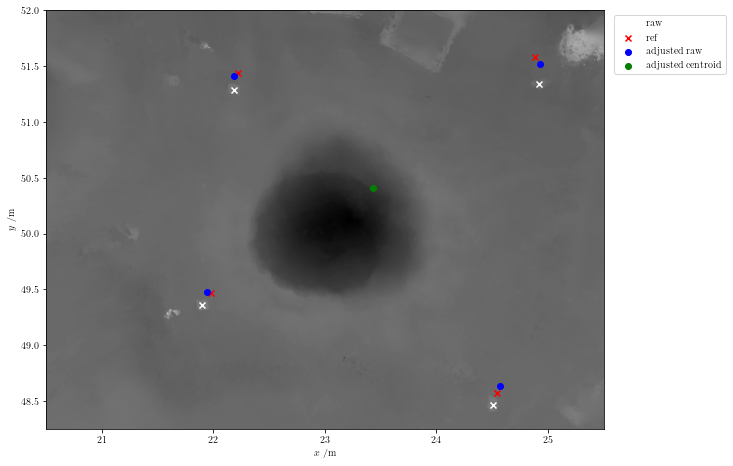

In [59]:
plt.close('all')
fig, ax = plt.subplots()

show_adjust(ax, ds, raw, ref, pivot=(cx, cy), trnf=tr2)
ax.set_xlim(20.5, 25.5); ax.set_ylim(48.25, 52)
# fig

### Rotate raster data to match reference transform

In [60]:
b2 = rotate_raster(b1, pars[3], pivot=(ciy, cix))
b2 += pars[2]
b2.mask = np.isnan(b2.data)

In [61]:
rtrans = atr * ds.transform
fstub = f"pad3_{rtrans.a * 1e3:.3f}mm_"
fstub

'pad3_1.425mm_'

In [62]:
make_geotiff(dataloc / f"{fstub}dem.geo.tif", data=b2, pds=ds,
             alt_transform=rtrans, add_mask=b2.mask)

In [63]:
ds2 = rasterio.open(dataloc / f'{fstub}dem.geo.tif', mode='r')
b2 = ds2.read(1, masked=True)

(48.25, 52.0)

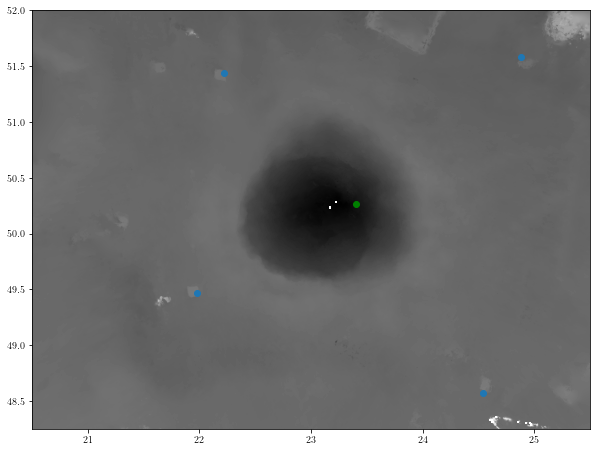

In [64]:
plt.close('all')
fig, ax = plt.subplots()
show(ds2, ax=ax, cmap=plt.cm.gray)
ax.scatter(*ds2.transform * (cix, ciy), c='g')
ax.scatter(ref[:, 0], ref[:, 1])
ax.set_xlim(20.5, 25.5); ax.set_ylim(48.25, 52)
# fig

#### Hillshade from DEM

In [65]:
make_viewable_geotiff(dataloc / f"{fstub}dem.tif", b2, ds2,
                      alt_transform=rtrans, add_mask=b2 > -1.2, add_jpeg=True)

In [66]:
h1 = fancy_hillshade(b2, ds2.files[0], amp=0.25)

In [67]:
fig, ax = plt.subplots()
show(h1, ax=ax, transform=ds2.transform, cmap=plt.cm.gray)
ax.set_xlim(20.5, 25.5); ax.set_ylim(48.25, 52)
# fig

(48.25, 52.0)

In [68]:
make_viewable_geotiff(dataloc / f"{fstub}hillshade.tif", h1, ds,
                      alt_transform=rtrans, add_mask=b2 > -1.2, add_jpeg=True)

## Pad 4

Original file location was `../data/GraettingerDEMs/pad4high/w001001.adf`

Spatial resolution of DEM (m / px)

In [69]:
ds = rasterio.open(dataloc / 'Pad4/elevation/w001001.adf')
ds.res

(0.002232816842, 0.002232816842)

In [70]:
b1 = ds.read(1, masked=True)
# b1.set_fill_value(np.nan)

### Corner blocks

- `raw`: Where the blocks show up in the raster.
- `ref`: Where the blocks should be, according to total station measurements.

In [71]:
raw = np.array([
    [25.179, 51.387, -1.360], [27.526, 50.778, -1.330],
    [24.923, 48.789, -1.240], [27.375, 49.045, -1.270]
])
ref = np.array([
    [25.177, 51.438, -1.358], [27.760, 50.561, -1.323],
    [24.525, 48.546, -1.289], [27.442, 48.646, -1.292]
])

For pad 4 pivot point of adjustment transform is the upper left block location

In [72]:
crawx, crawy = raw[0, :2]
crawx, crawy

(25.179, 51.387)

Raster index of pivot point

In [73]:
ciy, cix = ds.index(crawx, crawy)
ciy, cix

(2449, 3029)

For pad 4 the fitting routine did not work. It was faster to figure out adjustments
manually

In [74]:
ϕ = -5.0
scale = 1.125

atr =  Affine.translation(crawx, crawy) \
    * Affine.scale(scale) \
    * Affine.translation(-crawx, -crawy)

tr2 =  Affine.translation(crawx, crawy) \
    * Affine.rotation(ϕ) \
    * Affine.scale(scale) \
    * Affine.translation(-crawx, -crawy)
tr2

Affine(1.1207190353532137, 0.09805021059111561, -8.078090762804226,
       -0.09805021059111561, 1.1207190353532137, -3.7345828172218987)

Show adjustments

In [75]:
raw

array([[25.179, 51.387, -1.36 ],
       [27.526, 50.778, -1.33 ],
       [24.923, 48.789, -1.24 ],
       [27.375, 49.045, -1.27 ]])

In [76]:
centroid(ref[:,0], ref[:, 1])

(26.226, 49.79774999999999)

In [77]:
tr2

Affine(1.1207190353532137, 0.09805021059111561, -8.078090762804226,
       -0.09805021059111561, 1.1207190353532137, -3.7345828172218987)

(48.25, 52.0)

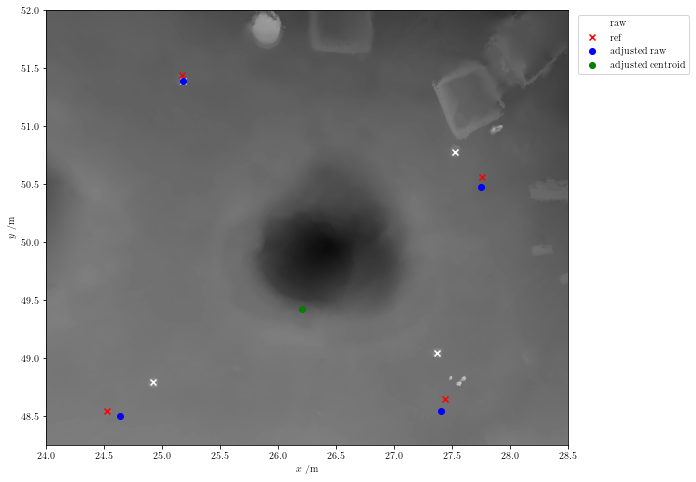

In [78]:
plt.close('all')
fig, ax = plt.subplots()
show_adjust(ax, ds, raw, ref, pivot=(crawx, crawy), trnf=tr2)
ax.set_xlim(24, 28.5); ax.set_ylim(48.25, 52)
# fig

In [79]:
ref[:, 2] - raw[:, 2]

array([ 0.002,  0.007, -0.049, -0.022])

In [80]:
zcorr = np.average(ref[:, 2] - raw[:, 2])
zcorr

-0.015499999999999958

### Rotate raster data to match reference transform

In [81]:
b2 = rotate_raster(b1, angle=ϕ, pivot=(ciy, cix))
b2 += zcorr
b2.mask = np.isnan(b2.data)

Load charge coordinates as additional visual reference.

In [82]:
charge_coords = np.loadtxt(dataloc / 'Pad4/charge-coords_site-crs.csv',
                           delimiter=',', skiprows=1)
charge_coords

array([[25.988 , 49.668 , -1.7155],
       [26.317 , 50.168 , -1.7155],
       [26.581 , 49.628 , -1.7155],
       [25.988 , 49.668 , -2.0155],
       [26.317 , 50.168 , -2.0155],
       [26.581 , 49.628 , -2.0155]])

Centroid of charge coordinates

In [83]:
ccenter = charge_coords[:3, :2].sum(axis=0) / 3
ccenter

array([26.29533333, 49.82133333])

In [84]:
rtrans = atr * ds.transform
fstub = f"pad4_{rtrans.a * 1e3:.3f}mm_"

In [85]:
make_geotiff(dataloc / f"{fstub}dem.geo.tif", data=b2, pds=ds,
             alt_transform=rtrans)

In [86]:
ds2 = rasterio.open(dataloc / f'{fstub}dem.geo.tif', mode='r')
b2 = ds2.read(1, masked=True)

The charge locations seem to be somewhat off. It is likely that someone slightly bumped into the theodolite before measuring the blocks of pad 4 (but after measuring pad 3, since that pad seems very consistent...).

In [87]:
plt.close('all')
fig, ax = plt.subplots()
show(ds2, ax=ax, cmap=plt.cm.gray)
ax.scatter(*ds2.transform * (cix, ciy), c='g')
ax.scatter(*centroid(charge_coords[:3, 0], charge_coords[:3, 1]), c='yellow')
ax.scatter(ref[:, 0], ref[:, 1])
ax.plot(*ccenter, color='white', marker='o', fillstyle='none', ls='none')
ax.scatter(charge_coords[:3, 0], charge_coords[:3, 1], color='red', marker='x')
ax.set_xlim(24, 28.5); ax.set_ylim(48.25, 52)
# fig

(48.25, 52.0)

Search for crater's minimum elevation

In [88]:
ds.index(25, 50.5), ds.index(28, 48.5)

((2847, 2949), (3742, 4292))

In [89]:
zmin = b2[2847:3742, 2949:4292].min()
zmin

-1.8077525

Raster index of min

In [90]:
np.where(b2 == zmin)

(array([3136]), array([3535]))

Coordinates of min

In [91]:
xmin, ymin = ds2.xy(3136, 3535)
xmin, ymin

(26.450708041518, 49.66245350222437)

Min is some ~20 cm off the charge coordinates centroid...

In [92]:
ccenter - np.array([xmin, ymin])

array([-0.15537471,  0.15887983])

In [93]:
ax.scatter([xmin], [ymin], marker='o', c='green')

In [94]:
fig

In [95]:
shift = Affine.translation(ccenter[0] - xmin, ccenter[1] - ymin)
shift * (xmin, ymin)

(26.295333333333332, 49.821333333333335)

In [96]:
rtrans = shift * ds2.transform
rtrans

Affine(0.00251191894725, 0.0, 17.414443895330958,
       0.0, -0.00251191894725, 57.69996711138296)

In [97]:
make_geotiff(dataloc / f"{fstub}dem.3.geo.tif", data=b2, pds=ds2,
             alt_transform=rtrans)

In [98]:
ds3 = rasterio.open(dataloc / f'{fstub}dem.3.geo.tif', mode='r')
b3 = ds3.read(1, masked=True)

Corrected reference block coordinates

In [99]:
cref = np.array([list(shift * el) for el in ref[:, :2]])
cref

array([[25.02162529, 51.59687983],
       [27.60462529, 50.71987983],
       [24.36962529, 48.70487983],
       [27.28662529, 48.80487983]])

(48.25, 52.0)

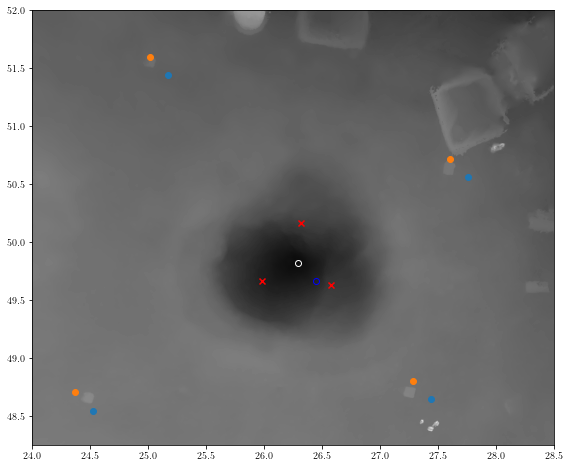

In [100]:
plt.close('all')
fig, ax = plt.subplots()
show(ds3, ax=ax, cmap=plt.cm.gray)
ax.scatter(ref[:, 0], ref[:, 1])
ax.scatter(cref[:, 0], cref[:, 1])
ax.plot(*ccenter, color='white', marker='o', fillstyle='none', ls='none')
ax.plot(xmin, ymin, color='b', marker='o', fillstyle='none', ls='none')
ax.scatter(charge_coords[:3, 0], charge_coords[:3, 1], color='red', marker='x')
ax.set_xlim(24, 28.5); ax.set_ylim(48.25, 52)
# fig

#### Hillshade from DEM

In [101]:
make_viewable_geotiff(dataloc / f"{fstub}dem.3.tif", b3, ds3, add_mask=b3 > -1.2,
                      add_jpeg=True)

In [102]:
h1 = fancy_hillshade(b3, ds3.files[0], amp=0.25)

In [103]:
plt.close('all')
fig, ax = plt.subplots()
show(h1, ax=ax, transform=ds3.transform, cmap=plt.cm.gray)
# ax.scatter(cref[:, 0], cref[:, 1])
ax.scatter(charge_coords[:3, 0], charge_coords[:3, 1], color='red', marker='x')
ax.set_xlim(24, 28.5); ax.set_ylim(48.25, 52)
# fig

(48.25, 52.0)

In [104]:
make_viewable_geotiff(target=dataloc / f"{fstub}hillshade.3.tif",
                      data=h1, pds=ds3, add_mask=b3 > -1.2, add_jpeg=True)